In [1]:
from __future__ import annotations

import os 

from torch.utils.data import DataLoader, random_split

from mmpfn.datasets.pad_ufes_20 import PADUFES20Dataset

import os 
import torch 
import numpy as np 
import pandas as pd

from math import ceil
from PIL import Image
from pathlib import Path
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, root_mean_squared_error

from mmpfn.models.mmpfn_v2 import MMPFNClassifier
from mmpfn.models.dino_v2.models.vision_transformer import vit_base
from mmpfn.models.mmpfn_v2.constants import ModelInterfaceConfig
from mmpfn.models.mmpfn_v2.preprocessing import PreprocessorConfig
from mmpfn.scripts_finetune_mm.finetune_tabpfn_main import fine_tune_tabpfn

/home/wall/works/research/MultiModalPFN/mmpfn/models/dino_v2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/wall/works/research/MultiModalPFN/mmpfn/models/dino_v2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/wall/works/research/MultiModalPFN/mmpfn/models/dino_v2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [2]:
data_path = os.path.join(os.getenv('HOME'), "works/research/MultiModalPFN/mmpfn/data/pad_ufes_20")
dataset = PADUFES20Dataset(data_path)
_ = dataset.get_embeddings(type='patch')

Load embeddings from embeddings/pad_ufes_20/pad_ufes_20_patch.pt


In [3]:
train_len = int(len(dataset) * 0.8)
test_len = len(dataset) - train_len

train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

In [ ]:
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
for batch in train_loader:
    x_sample, embedding_sample, y_sample = batch
    print("len(train_dataset)", len(train_dataset))
    print("len(train_loader):", len(train_loader))
    print(f"Batch size: {x_sample.shape[0]}")
    print(f"Features shape: {x_sample.shape}")
    print(f"Embedding shape: {embedding_sample.shape}")
    print(f"Labels shape: {y_sample.shape}")
    break  # Just to test the first batch

len(train_loader): 733
Batch size: 16
Features shape: torch.Size([16, 19])
Embedding shape: torch.Size([16, 576, 768])
Labels shape: torch.Size([16])


In [ ]:
for batch in test_loader:
    x_sample, embedding_sample, y_sample = batch
    print("len(train_dataset)", len(train_dataset))
    print("len(test_loader):", len(test_loader))
    print(f"Batch size: {x_sample.shape[0]}")
    print(f"Features shape: {x_sample.shape}")
    print(f"Embedding shape: {embedding_sample.shape}")
    print(f"Labels shape: {y_sample.shape}")
    break  # Just to test the first batch

len(test_loader): 184
Batch size: 16
Features shape: torch.Size([16, 19])
Embedding shape: torch.Size([16, 576, 768])
Labels shape: torch.Size([16])


In [ ]:
X_train, X_test, image_train, image_test, y_train, y_test = train_test_split(
    train[col_features], X_image, train[col_target], test_size=0.2
)

for col, any_na in X_train.isna().any().items():
    if any_na:
        X_train[col] = X_train[col].fillna(0)

for col, any_na in X_test.isna().any().items():
    if any_na:
        X_test[col] = X_test[col].fillna(0)


In [ ]:
torch.cuda.empty_cache()

In [ ]:
save_path_to_fine_tuned_model = "./finetuned_mmpfn_adoption_0727_1.ckpt"

Fine-tuning Steps: 3it [00:12,  6.33s/it, Best Val. Loss=1.35, Best Val. Score=-1.35, Training Loss=1.33, Val. Loss=1.35, Patience=48, Utilization=0, Grad Norm=0.806]                       
[2025-08-07 22:34:35,067] INFO - === Fine-Tuning Report for TabPFN ===
        	Total Time Spent: 14.802227258682251
        	Initial Validation Loss: 	 1.351112926804872
        	Best Validation Loss: 	 1.3485573061091747
        	Total Steps: 3
        	Best Step: 2
        	Avg. Time per Step: 4.934080759684245
        	Avg. Device Utilization: 0.0
        


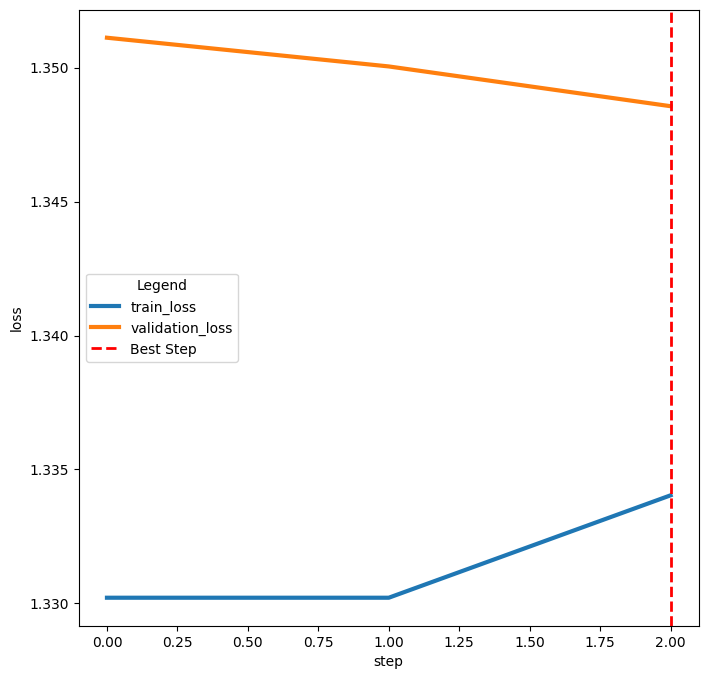

In [ ]:
fine_tune_tabpfn(
    # path_to_base_model="auto",
    save_path_to_fine_tuned_model=save_path_to_fine_tuned_model,
    # Finetuning HPs
    time_limit=60,
    finetuning_config={"learning_rate": 0.00001, "batch_size": 2, "max_steps": 2},
    validation_metric="log_loss",
    # Input Data
    X_train=X_train,
    # image_train=image_train,
    image_train=None,
    y_train=y_train,
    categorical_features_index=None,
    device="cuda",  # use "cpu" if you don't have a GPU
    task_type="multiclass",
    # Optional
    show_training_curve=True,  # Shows a final report after finetuning.
    logger_level=0,  # Shows all logs, higher values shows less
    freeze_input=True,  # Freeze the input layers (encoder and y_encoder) during finetuning
    mixer_type='token_append' # no_append, token_append, split_append
)

In [ ]:
# disables preprocessing at inference time to match fine-tuning
no_preprocessing_inference_config = ModelInterfaceConfig(
    FINGERPRINT_FEATURE=False,
    PREPROCESS_TRANSFORMS=[PreprocessorConfig(name='none')]
)

# Evaluate on Test Data
model_finetuned = MMPFNClassifier(
    model_path=save_path_to_fine_tuned_model,
    inference_config=no_preprocessing_inference_config,
    ignore_pretraining_limits=True,
    mixer_type='no_append' # no_append, token_append, split_append
)
# clf_finetuned = model_finetuned.fit(X_train, image_train, y_train)
clf_finetuned = model_finetuned.fit(X_train, None, y_train)

# print("accuracy_score (Finetuned):", accuracy_score(y_test, clf_finetuned.predict(X_test, image_test)))
print("accuracy_score (Finetuned):", accuracy_score(y_test, clf_finetuned.predict(X_test, None)))

/home/wall/works/research/MultiModalPFN/mmpfn/models/mmpfn_v2/classifier.py:399: UserWarning: Number of samples 11721 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


accuracy_score (Finetuned): 0.3995223473217332


In [ ]:
# # Compare to the default model
# model_default = MMPFNClassifier(
#     model_path = "parameters/tabpfn-v2-classifier.ckpt",
#     ignore_pretraining_limits=True,
# )
# # clf_default = model_default.fit(X_train, image_train, y_train)
# clf_default = model_default.fit(X_train, None, y_train)

# # print("accuracy_score (Default):", accuracy_score(y_test, clf_default.predict(X_test, image_test)))
# print("accuracy_score (Default):", accuracy_score(y_test, clf_default.predict(X_test, None)))